In [1]:
from ml_pipeline import forecasting_pipeine
from helpers.utils import read_csv
from helpers.ml import MAPE
import pandas as pd
import datetime
from dateutil.relativedelta import relativedelta
import gc
import matplotlib.pyplot as plt

In [2]:
sales = read_csv(r'../data/sales.csv')
taxonomy = read_csv(r'../data/product_taxonomy.csv')
stores = read_csv(r'../data/store_cities.csv')

Mem. usage decreased from 8412.51 Mb to 8004.33 Mb (4.9% reduction)
Mem. usage decreased from  0.31 Mb to  0.31 Mb (2.6% reduction)
Mem. usage decreased from  0.03 Mb to  0.03 Mb (3.6% reduction)


In [3]:
data = pd.merge(sales, taxonomy, how='inner', on = ['product_id'])\
         .merge(stores, how='inner', on = ['store_id'])

In [4]:
del sales, taxonomy, stores
gc.collect()

62

# Create predictions

We need to make daily forecasting for October 2019

Baselines

- average YoY sales based on seasonality (average sales by same dates in previous years multiplied by YoY trend)
- Facebook Prophet

Model (LightGBM model with recursive prediction schema)

- Recursive approach is based on using predictions as features for new predictions. E. g. we predicted sales for January 1st to use this prediction as a feature for January 2nd


In [7]:
prediction_end_dates = pd.date_range(datetime.datetime(
    2019, 1, 1), datetime.datetime(2019, 11, 1), freq='M')
results = pd.DataFrame()


for prediction_end_date in prediction_end_dates:

    train_start_date = datetime.datetime(2017, 1, 1)

    test_start_date = prediction_end_date - \
        relativedelta(months=2) + relativedelta(days=1)

    prediction_start_date = prediction_end_date - \
        relativedelta(months=1) + relativedelta(days=1)
    test_end_date = prediction_start_date - relativedelta(days=1)

    train_end_date = test_start_date - relativedelta(days=1)

    print('')
    print(f'''Forecasting for parameters:''')
    print(
        f'''Training range: {train_start_date.date()}, {train_end_date.date()}''')
    print(
        f'''Validation range: {test_start_date.date()}, {test_end_date.date()}''')
    print(
        f'''Prediction range: {prediction_start_date.date()}, {prediction_end_date.date()}''')

    cfg = {}
    cfg['MODEL'] = \
        {
            "train_start_date" : train_start_date, "train_end_date" : train_end_date,
             "test_start_date" : test_start_date, "test_end_date" : test_end_date,
             "prediction_start_date" : prediction_start_date, "prediction_end_date" : prediction_end_date
        }

    prediction_results = forecasting_pipeine(data[data.date <= str(prediction_end_date)[:10]], cfg, output_predictions=False)

    prediction_results['prediction_period'] = prediction_end_date

    for score_name, model_name in zip(['lgb_predicted', 'predicted_seasonal_average', 'predicted_fbprophet'],
                                      ['LGB', 'Average YoY', 'FBProphet']):

        print('MAPE by {0} model : {1:0.1} %'.format(model_name, MAPE(
            prediction_results['sales'], prediction_results[score_name])))

    results = results.append(prediction_results, ignore_index=True)
    results.to_csv(r'../output/results.csv', index=False)

# Compare LightGBM model against baselines

In [28]:
results = pd.read_csv(r'../output/results.csv')
results['date'] = pd.to_datetime(results['date'], format='%Y-%m-%d')
prediction_pairs = results[['hierarchy1_id', 'storetype_id']].drop_duplicates()

In [20]:
results.head()

,date,hierarchy1_id,storetype_id,sales,lgb_predicted,predicted_seasonal_average,predicted_fbprophet,prediction_period,stacked
0,2019-01-01,H00,ST01,555.31400,715.042216,571.645996,507.271498,2019-01-31,679.925522
1,2019-01-02,H00,ST01,1880.03230,658.879983,596.410034,503.917296,2019-01-31,637.136719
2,2019-01-03,H00,ST01,354.27000,651.478092,567.219971,493.662023,2019-01-31,627.270673
3,2019-01-04,H00,ST01,443.06995,651.478092,650.463989,557.607180,2019-01-31,641.989591
4,2019-01-05,H00,ST01,650.20013,735.389693,884.380005,848.129507,2019-01-31,761.562705


In [46]:
score_cols = []
for score_name, model_score in zip(['LGB', 'FB Prophet', 'Seasonal YoY Average'], ['lgb_predicted', 'predicted_seasonal_average', 'predicted_fbprophet']):
    results['MAPE by %s' % score_name] = abs(
        results[model_score] - results['sales']) / (results['sales'] + 1)
    score_cols.append('MAPE by %s' % score_name)


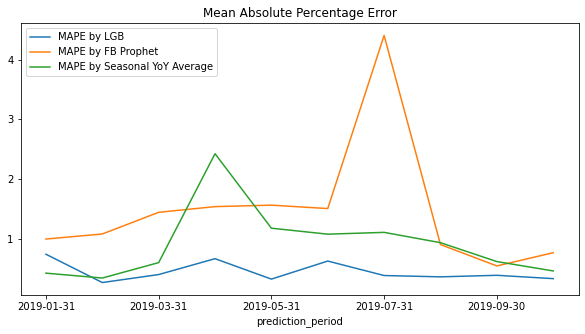

In [48]:

results.groupby(['prediction_period'])[score_cols].mean().plot(figsize=(10,5))
plt.title("Mean Absolute Percentage Error")
plt.show()

In [54]:
results.groupby(['prediction_period'])[score_cols].mean().round(3)*100

,MAPE by LGB,MAPE by FB Prophet,MAPE by Seasonal YoY Average
prediction_period,,,
2019-01-31,74.4,99.8,42.8
2019-02-28,27.1,108.3,34.6
2019-03-31,40.5,144.5,60.4
2019-04-30,67.0,154.0,242.5
2019-05-31,32.8,156.5,118.0
2019-06-30,63.0,150.8,108.0
2019-07-31,38.8,440.2,111.0
2019-08-31,36.6,90.6,93.8
2019-09-30,39.2,54.9,62.2


In [55]:
results.groupby(['hierarchy1_id', 'storetype_id'])[score_cols].mean().round(3)*100

MAPE by LGB  MAPE by FB Prophet  \
hierarchy1_id storetype_id                                    
H00           ST01                 22.3                55.4   
              ST02                 23.8                56.7   
              ST03                 12.7                56.0   
              ST04                 11.7                54.9   
H01           ST01                 31.0                59.1   
              ST02                 29.7                50.5   
              ST03                 32.5                70.2   
              ST04                 29.6                60.0   
H02           ST01                130.3               267.4   
              ST02                 82.4              1618.2   
              ST03                 98.4                94.3   
              ST04                 90.0                74.6   
H03           ST01                 28.5                57.5   
              ST02                 39.1                56.8   
              ST03                 37.5                62.8   
              ST04                 25.5                60.5   

                            MAPE by Seasonal YoY Average  
hierarchy1_id storetype_id                                
H00           ST01                                  19.2  
              ST02                                  16.7  
              ST03                                  13.3  
              ST04                                  12.4  
H01           ST01                                  37.6  
              ST02                                  36.8  
              ST03                                  34.2  
              ST04                                  30.7  
H02           ST01                                 416.3  
              ST02                                  59.7  
              ST03                                 131.6  
              ST04                                 464.0  
H03           ST01                                  47.5  
              ST02                                  51.0  
              ST03                                  61.7  
              ST04                                  39.0

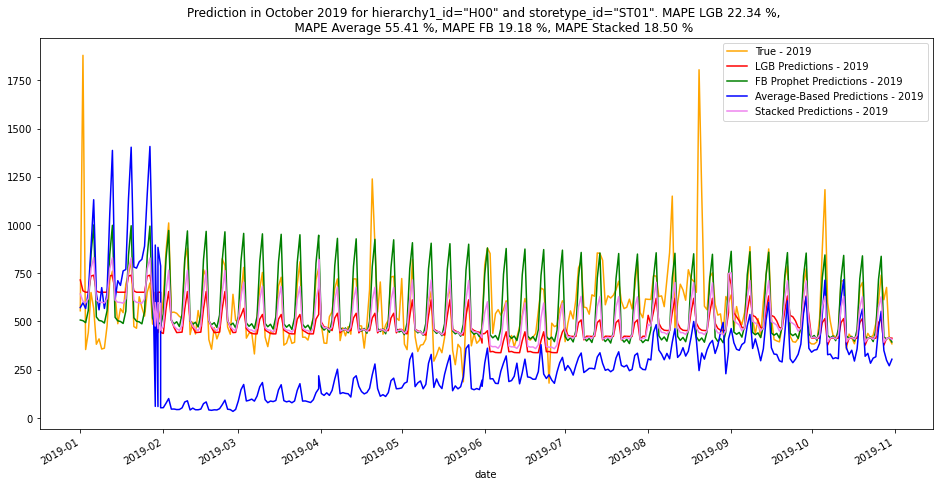

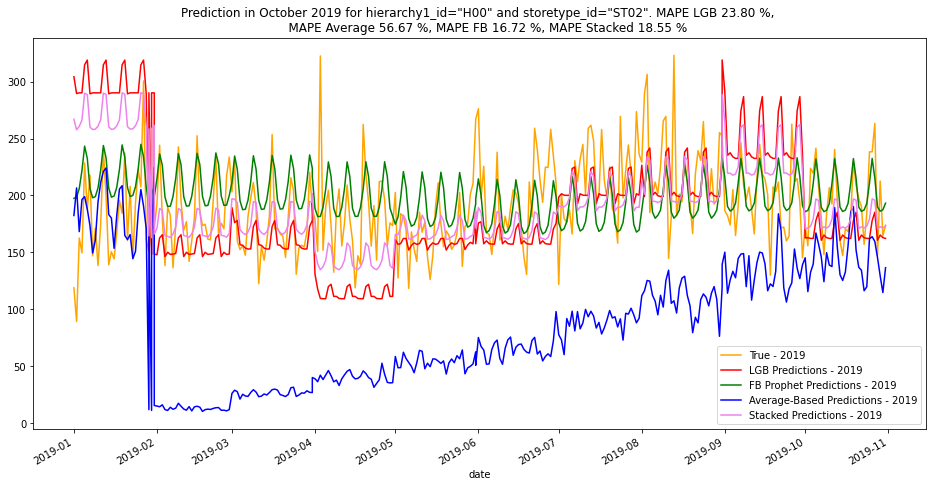

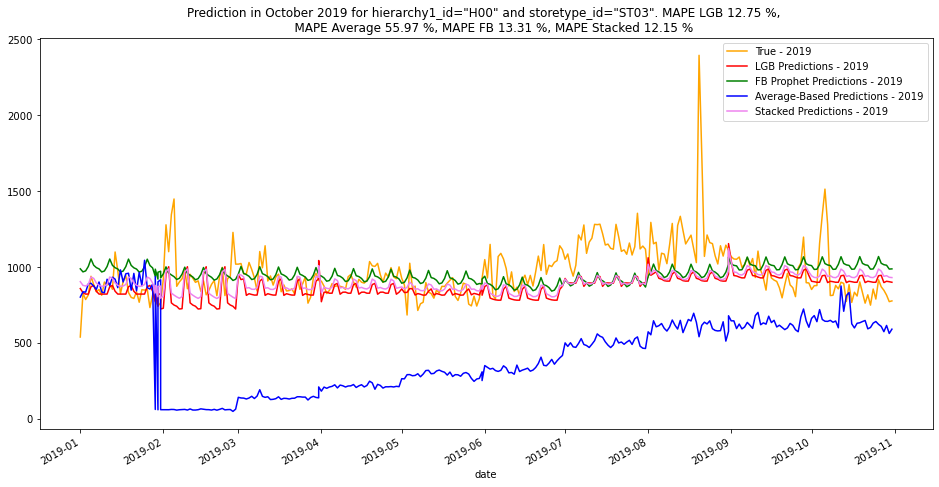

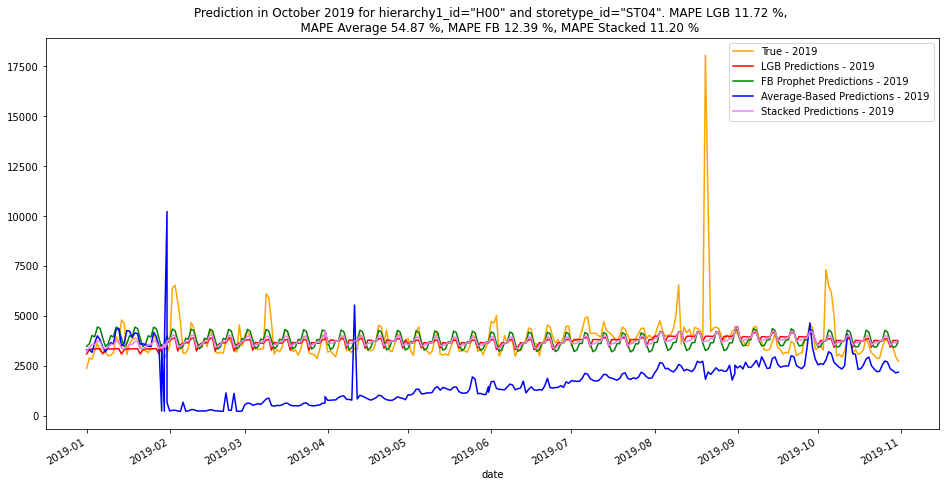

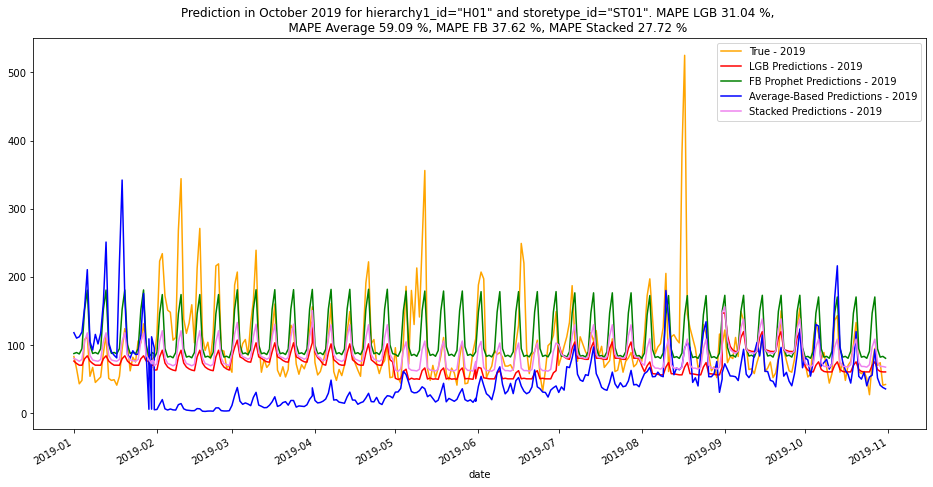

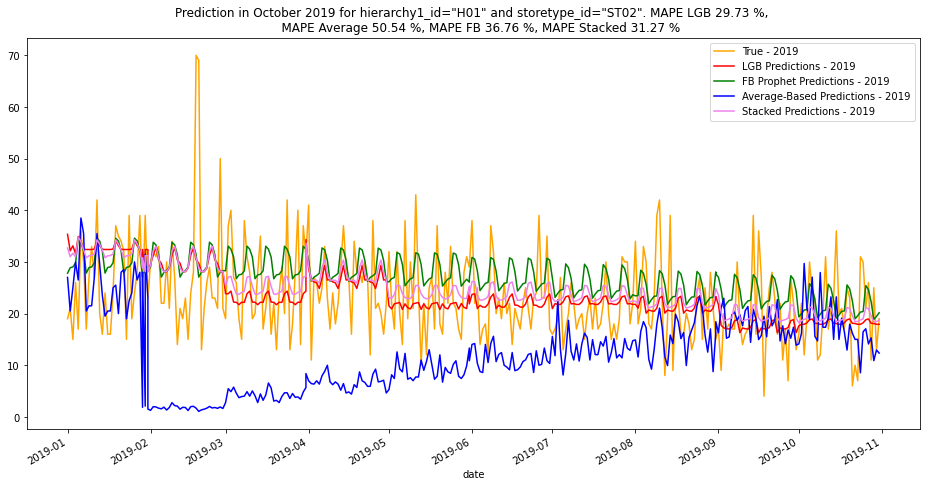

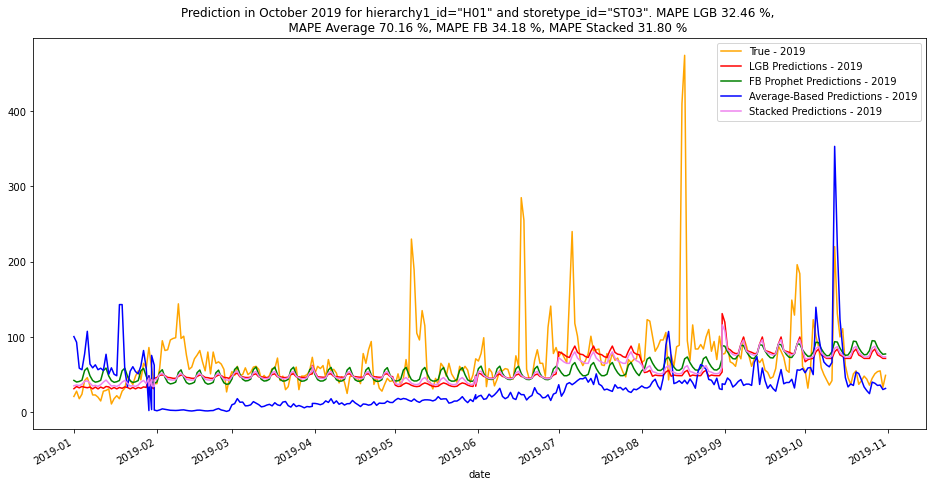

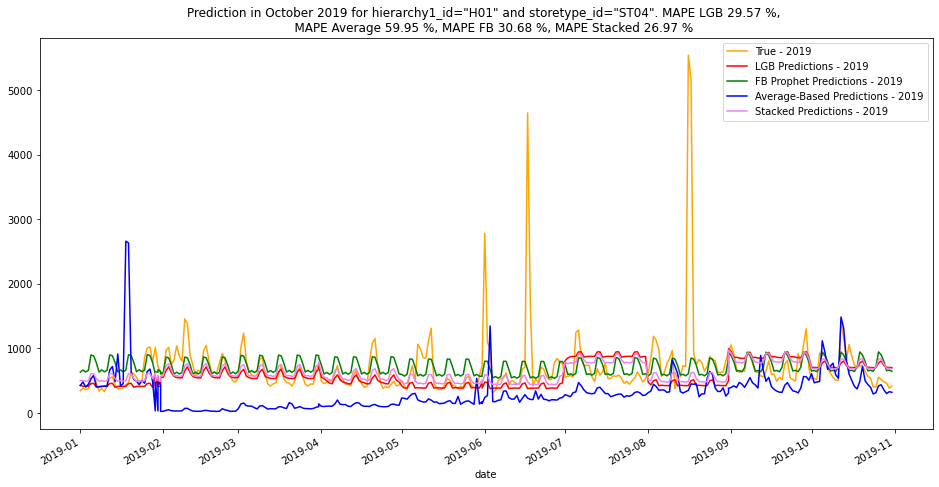

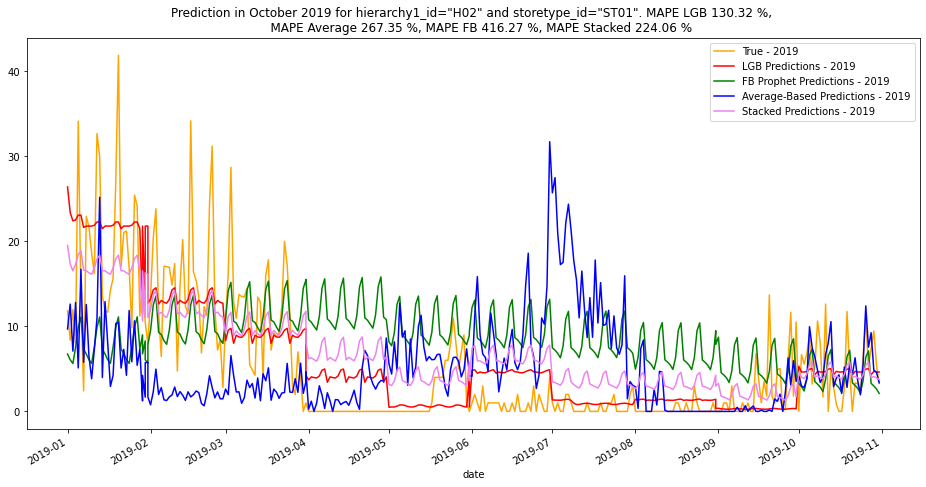

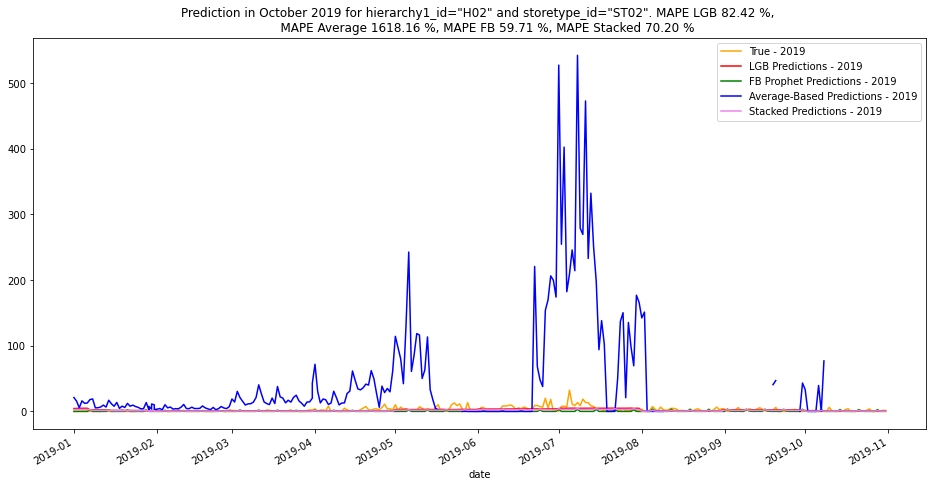

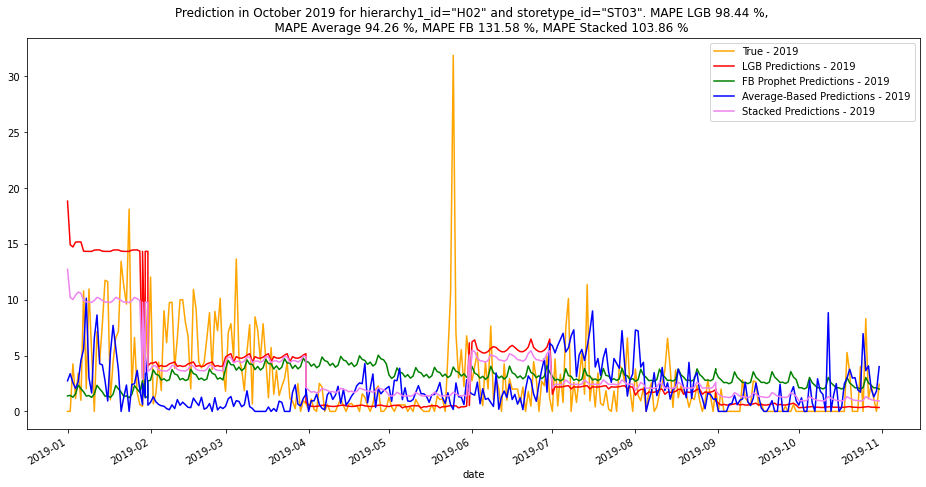

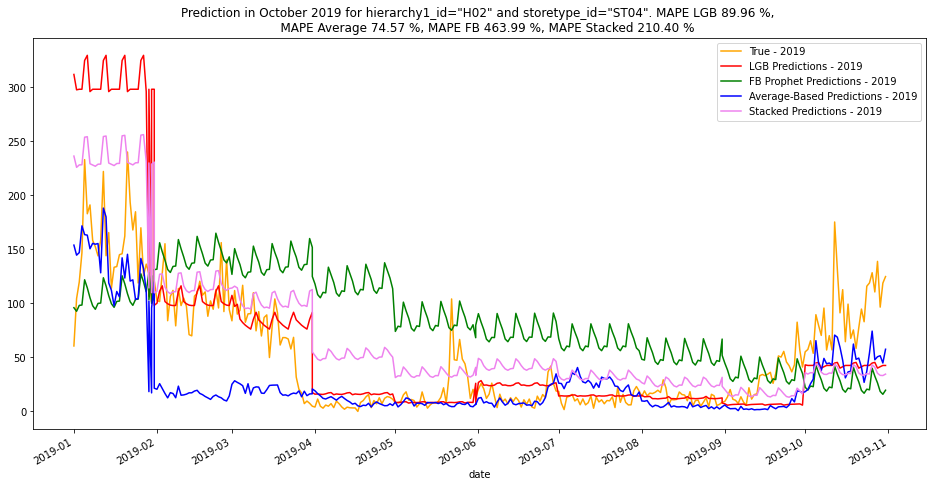

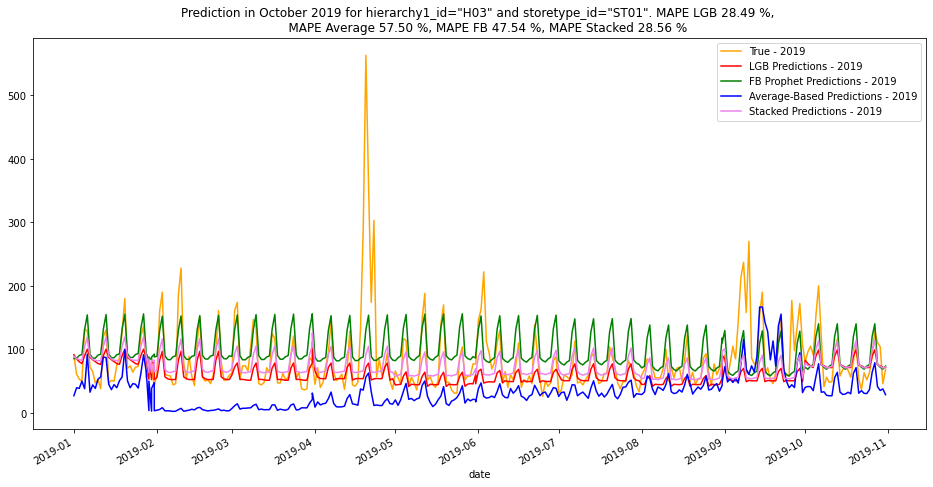

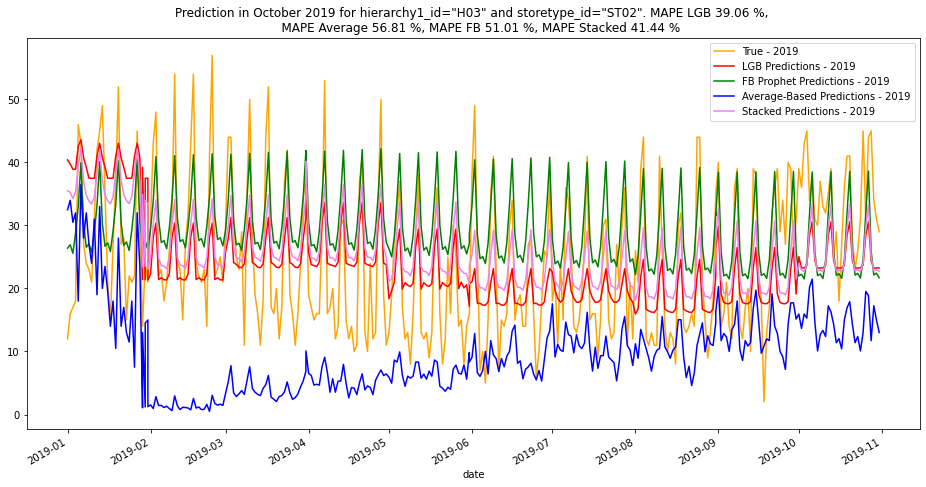

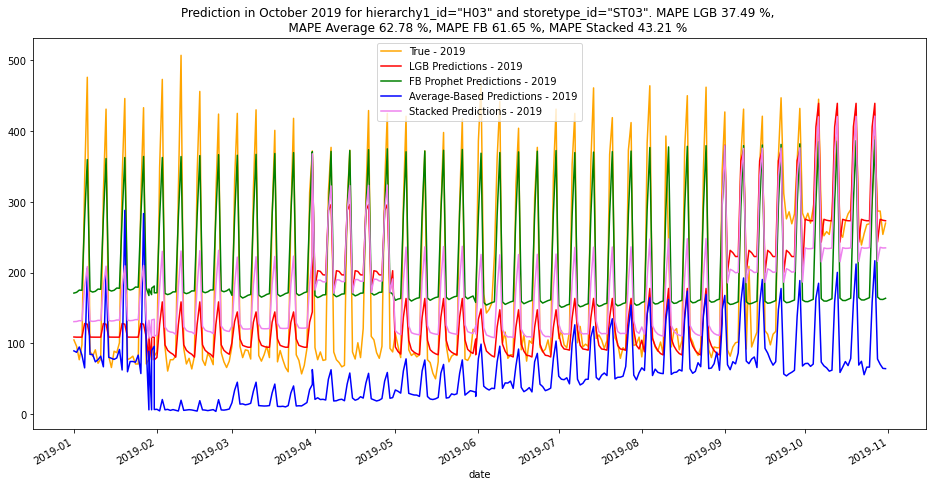

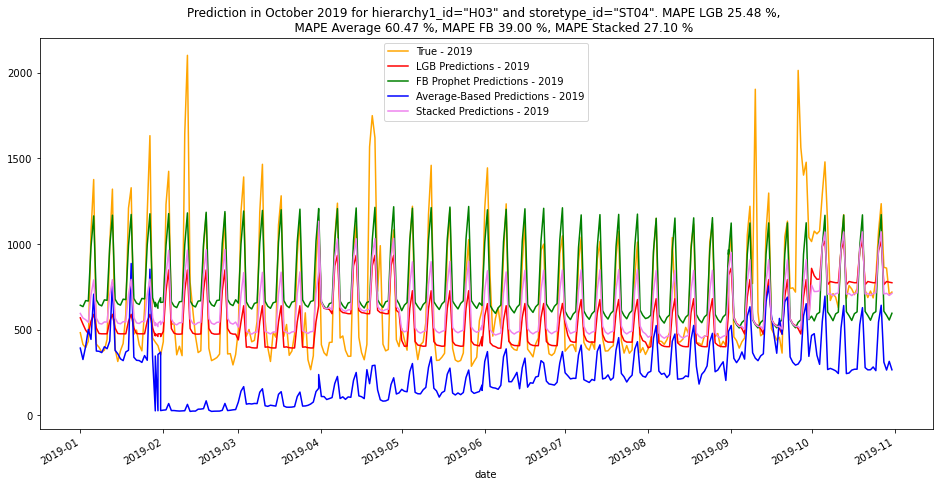

In [27]:
for pair in prediction_pairs.to_numpy():
    results[(results.hierarchy1_id == pair[0]) &
            (results.storetype_id == pair[1])].set_index('date')['sales'].plot(figsize=(16, 8), label='True - 2019', c='orange')
    results[(results.hierarchy1_id == pair[0]) &
            (results.storetype_id == pair[1])].set_index('date')['lgb_predicted'].plot(figsize=(16, 8), label='LGB Predictions - 2019', c='red')
    results[(results.hierarchy1_id == pair[0]) &
            (results.storetype_id == pair[1])].set_index('date')['predicted_fbprophet'].plot(figsize=(16, 8), label='FB Prophet Predictions - 2019', c='green')
    results[(results.hierarchy1_id == pair[0]) &
            (results.storetype_id == pair[1])].set_index('date')['predicted_seasonal_average'].plot(figsize=(16, 8), label='Average-Based Predictions - 2019', c='blue')

    results[(results.hierarchy1_id == pair[0]) &
            (results.storetype_id == pair[1])].set_index('date')['stacked'].plot(figsize=(16, 8), label='Stacked Predictions - 2019', c='violet')

    mape_lgb = \
        MAPE(results[(results.hierarchy1_id == pair[0]) &
                     (results.storetype_id == pair[1])]['sales'], results[(results.hierarchy1_id == pair[0]) &
                                                                          (results.storetype_id == pair[1])]['lgb_predicted'])

    mape_fb = \
        MAPE(results[(results.hierarchy1_id == pair[0]) &
                     (results.storetype_id == pair[1])]['sales'], results[(results.hierarchy1_id == pair[0]) &
                                                                          (results.storetype_id == pair[1])]['predicted_fbprophet'])

    mape_avg = \
        MAPE(results[(results.hierarchy1_id == pair[0]) &
                     (results.storetype_id == pair[1])]['sales'], results[(results.hierarchy1_id == pair[0]) &
                                                                          (results.storetype_id == pair[1])]['predicted_seasonal_average'])

    mape_stacked = \
        MAPE(results[(results.hierarchy1_id == pair[0]) &
                     (results.storetype_id == pair[1])]['sales'], results[(results.hierarchy1_id == pair[0]) &
                                                                          (results.storetype_id == pair[1])]['stacked'])

    plt.title('''Prediction in October 2019 for hierarchy1_id="{0}" and storetype_id="{1}". MAPE LGB {2:0.2f} %, 
    MAPE Average {3:0.2f} %, MAPE FB {4:0.2f} %, MAPE Stacked {5:0.2f} %'''
              .format(pair[0], pair[1], mape_lgb, mape_avg, mape_fb, mape_stacked))

    plt.legend()
    plt.show()
